In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
df = pd.read_csv("/content/Telco_Cusomer_Churn.csv")

if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)


In [4]:
print("\nDataset Shape:", df.shape)


Dataset Shape: (7043, 20)


In [5]:
print("\nData Types:")
print(df.dtypes)


Data Types:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2281.916928
std         0.368612    24.559481       30.090047   2265.270398
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    402.225000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000


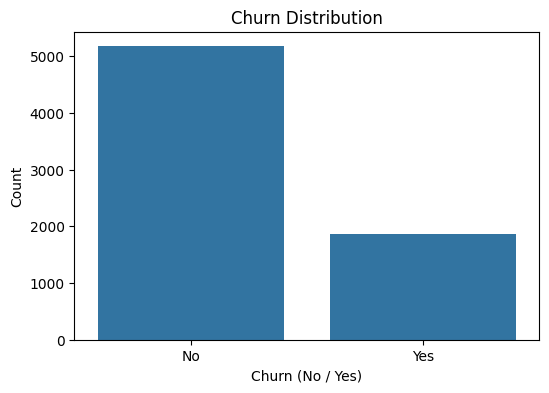

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.xlabel("Churn (No / Yes)")
plt.ylabel("Count")
plt.show()

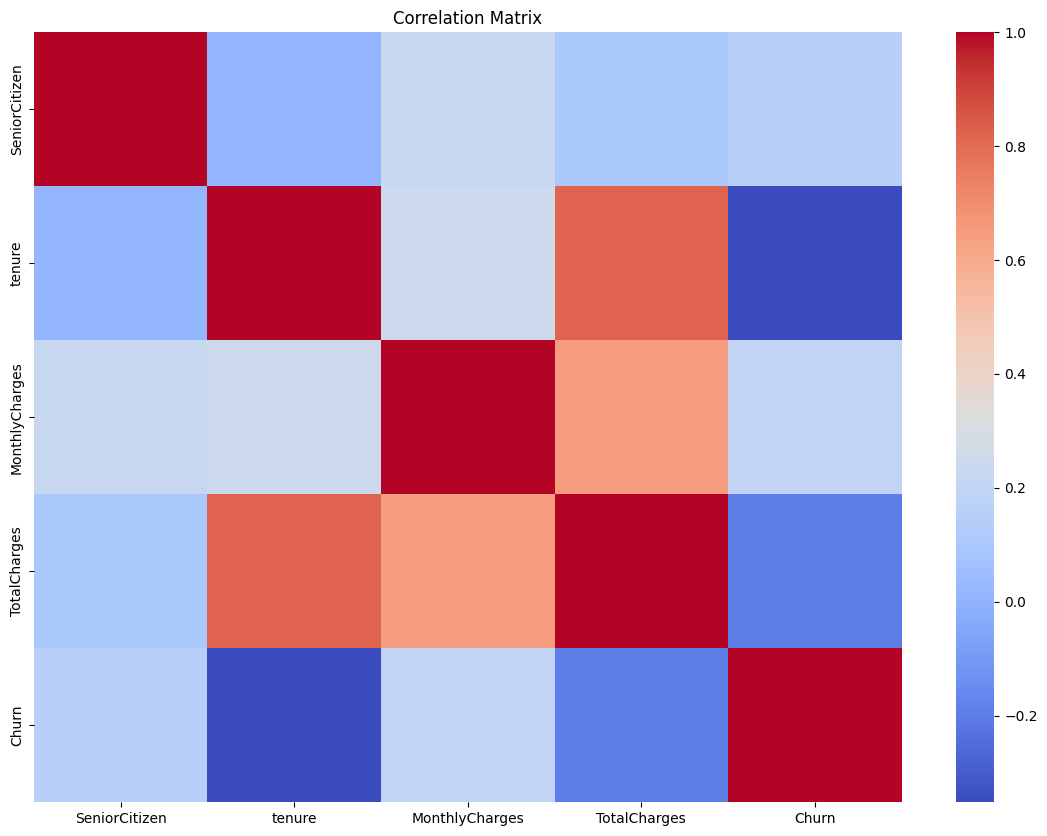


Feature Correlation with Churn:
Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199037
tenure           -0.352229
Name: Churn, dtype: float64


In [9]:
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

print("\nFeature Correlation with Churn:")
print(corr_matrix['Churn'].sort_values(ascending=False))

In [10]:
encoders = {}
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':  # do not encode target
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

# Encode target
target_le = LabelEncoder()
df['Churn'] = target_le.fit_transform(df['Churn'])



In [11]:
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
smote = SMOTE(random_state=42)
X_scaled, y = smote.fit_resample(X_scaled, y)

In [13]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}


In [19]:
splits = [(0.2,"80-20"), (0.25,"75-25"), (0.3,"70-30")]

best_score = 0
best_model = None
best_X_test = None
best_y_test = None
best_split = None
X_train_final = None
y_train_final = None


accuracy_results = {}

for test_size, name in splits:

    print("\n====================")
    print("Split:", name)
    print("====================")

    accuracy_results[name] = {}

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size,
        random_state=42, stratify=y
    )

    for model_name, model in models.items():

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        acc = accuracy_score(y_test, pred)
        print(model_name, "Accuracy:", acc)


        accuracy_results[name][model_name] = acc

        if acc > best_score:
            best_score = acc
            best_model = model
            best_X_test = X_test
            best_y_test = y_test
            best_split = name
            X_train_final = X_train
            y_train_final = y_train



Split: 80-20
Random Forest Accuracy: 0.8584541062801933
Gradient Boosting Accuracy: 0.8386473429951691
AdaBoost Accuracy: 0.8038647342995169
SVM Accuracy: 0.8009661835748793
XGBoost Accuracy: 0.8516908212560387

Split: 75-25
Random Forest Accuracy: 0.8596830305373019
Gradient Boosting Accuracy: 0.8422883649014302
AdaBoost Accuracy: 0.8024739080015462
SVM Accuracy: 0.8059528411287206
XGBoost Accuracy: 0.8438345574023965

Split: 70-30
Random Forest Accuracy: 0.8518518518518519
Gradient Boosting Accuracy: 0.8405797101449275
AdaBoost Accuracy: 0.7958132045088567
SVM Accuracy: 0.8028985507246377
XGBoost Accuracy: 0.8460547504025765


<Figure size 1200x600 with 0 Axes>

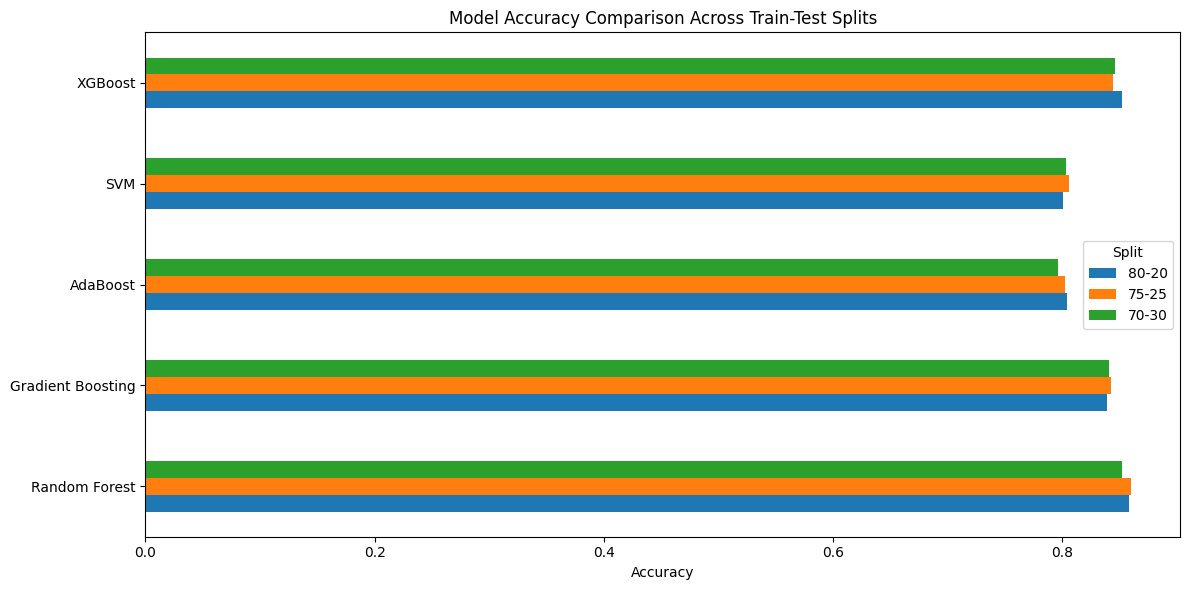

In [20]:

acc_df = pd.DataFrame(accuracy_results)

plt.figure(figsize=(12,6))
acc_df.plot(kind='barh', figsize=(12,6))
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison Across Train-Test Splits")
plt.legend(title="Split")
plt.tight_layout()
plt.show()



              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1294
           1       0.84      0.88      0.86      1293

    accuracy                           0.86      2587
   macro avg       0.86      0.86      0.86      2587
weighted avg       0.86      0.86      0.86      2587



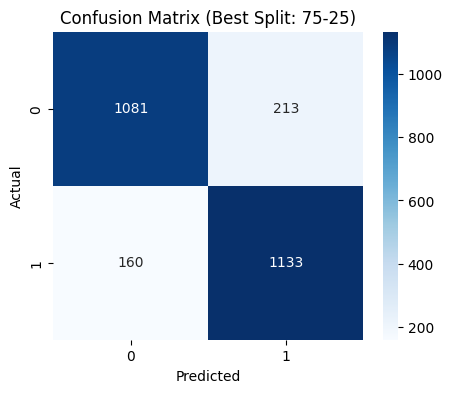

In [21]:
final_pred = best_model.predict(best_X_test)

print(classification_report(best_y_test, final_pred))

cm = confusion_matrix(best_y_test, final_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Best Split: {best_split})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [23]:
pipeline = {
    "model": best_rf,
    "scaler": scaler,
    "feature_names": list(X.columns),
    "encoders": encoders,
    "target_le": target_le
}

with open("churn_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("FULL PIPELINE SAVED SUCCESSFULLY")

FULL PIPELINE SAVED SUCCESSFULLY
